# Einführung

Dieser Code ist eine Implementierung von Bildfiltern durch gewichteten Mittelwert, Median und Gaussches Gewicht. Der Prozess besteht aus zwei Schritten:
1. Konstruktion von mathematischen Formeln. Diese sind die Grundlage der Filterfunktionen und mit minimaler Hilfe von numpy geschrieben.
2. Implementierung von Formeln als Filtern. Bildern lassen sich als Matrizen mit Farbwerten auf jeden Eintrag (äquivalent zu einem einzelnen Pixel) identifizieren, und diese können zum Bildfiltern mithilfe obiger Formeln manipuliert werden. 

# Packages

In [2]:
import numpy as np
import skimage
from skimage import io
from skimage import data
from matplotlib import pyplot as plt

# Mathematische Formeln 

Imprementierung von mathematischen Formeln als Grundlage Filterprozess. Wie oben genannt, man kann Bilder als Matrizen identifizieren, was einfach 2D Arrays sind. 
* Gewichteter Mittelwert: elementweise Multiplikation der gegebenen Matrizen. W ist das Gewicht, wofür die Summe alle seine Einträge genau 1 ist. 
* Gewichteter Median: der Median von A nach der Verteilung von W. W ist wieder das Gewicht, und die Position (Index) von seinem Median ist angewendet, um den gewichteten Median von A zu finden. 
* Gauss1: generiert eine normal-verteilte Matrix (also ihre Einträge sind Gauss-verteilt). Die Größe der Matrix hängt von s ab (falls gegeben), sonst von V, was die gewünschte Standardabweichung ist. 
* Gauss2: rechnet den Wert der Gaussfunktion mit gegebenen Variablen. 

In [3]:
def gew_Mittel(A, W): #weighted mean. A, W = list 
    n, m = len(A), len(A[0])
    result = 0
    for k in range(n):
        for l in range(m):
            result += W[k][l] * A[k][l]
    return result

def gew_Med(A, W): #weighted median. A, W = list 
    med_index = 0
    mid = 0
    result, W2 = A.flatten(), W.flatten()
    result.sort()
    n = len(W) 
    while mid < 0.5:
        mid += W2[med_index]
        med_index += 1
    if mid == 0.5:
        return 0.5 * (result[med_index-1] + result[med_index])
    else:
        return result[med_index-1]

def Gauss1(V, s = None): #V = float, s = int > 0 
    if s == None: 
        s = int(3*(V//1))
    result = np.zeros((2*s+1, 2*s+1))
    for i in range(-s, s+1):
        for j in range(-s, s+1):
            x = -((i**2) + (j**2))
            y = 2 * (V**2)
            result[i+s, j+s] = np.exp(x/y)
    N = np.sum(result)
    for i in range(-s, s+1):
        for j in range(-s, s+1):
            result[i, j] = result[i, j] / N
    return result

def Gauss2(V, x): #V = float, s = int > 0 
    return np.exp(-(x**2) / (2 * V**2)) 

# Filterfunktionen

Diese Funktionen wenden die obigen Formeln auf das Bild an, um das Bild zu filtern. Sie ändern die Werte der Pixel abhängig von den Pixeln um sie. Die Werte sind aus einem 2sX2s Block um das Zielpixel. Für die Pixel an dem Rand, wofür es nicht garantiert ist, dass der Block existiert, wird der Block mit der extend Funktion fortgesetzt (siehe nächster Abschnitt)
* Mittelfilter: ändert den Zielpixelwert mit dem Mittelwert der Pixel um ihn.
* Medianfilter: ändert den Zielpixelwert mit dem Medianwert der Pixel um ihn.
* Bilateraler Filter: ändert den Zielpixelwert mit dem gewichteten Mittel mithilfe Gaußschen Verteilung. Für Details zur Berechnung siehe die Wikipedia-Seite zum bilateralen Filter.

In [4]:
def Mittelfilter(A, W): #Mean filter
    n, m = len(A), len(A[1])
    s = int((len(W)-1)/2)
    result = np.zeros((n, m))
    Aextended = extend(A, s) 
    #calculate mean 
    for i in range(0, n):
        for j in range(0, m):
            i2 = int(i+2*s+1)
            j2 = int(j+2*s+1)
            block = Aextended[i:i2, j:j2]
            result[i][j] = gew_Mittel(block, W)
    return result 

def Medianfilter(A, W): #Median filter 
    n, m = len(A), len(A[1])
    s = int((len(W)-1)/2)
    result = np.zeros((n, m))
    Aextended = extend(A, s) 
    #calculate median 
    for i in range(0, n):
        for j in range(0, m):
            i2 = int(i+2*s+1)
            j2 = int(j+2*s+1)
            block = Aextended[i:i2, j:j2]
            result[i, j] = gew_Med(block, W)
    result = result.astype(np.uint8)
    return result 

def Bilfilter(A, W, sigma): #Bilateral filter 
    n, m = len(A), len(A[1])
    s = int((len(W)-1)/2)
    result = np.zeros((n, m))
    Aextended = extend(A, s) 
    #calculate bilateral value.  
    for i in range(0, n):
        for j in range(0, m):
            denom = 0
            total = 0
            #calculate denominator
            for u in range(0, 2*s+1):
                for v in range(0, 2*s+1):
                    y = Aextended[s+i, s+j] - Aextended[i+u, j+v]
                    denom += (W[u, v] * Gauss2(sigma, y))
            #divide each value by denominator and add them up 
            for k in range(0, 2*s+1):
                for l in range(0, 2*s+1):
                    x = Aextended[s+i, s+j] - Aextended[i+k, j+l]
                    num = (W[k, l] * Gauss2(sigma, x))
                    total += (num / denom) * Aextended[i+k, j+l]
            result[i, j] = total
    return result 

# Hilfsfunktionen

* rechteck: generiert eine normalverteilte (2s+1)X(2s+1) Matrix. 
* extend: setzt die Dimension der gegebenen Matrix von nXm bis (n+2s)X(m+2s) fort. Das ist bei dem Rand des Bildes benötigt, den die Filtern nimmt die Werte von einem Bereich von ±2s. Diese Fortsetzung sind gespiegelte Werte von dem originellen Bild; das heißt, wenn das Zielwert von Index 0 ist, dann der Wert von Index -1 ist gleich zu dem Wert von Index 2, -2 zu 2 usw. 

In [8]:
def rechteck(s): #s = int > 0
    result = np.zeros((2*s+1, 2*s+1))
    for i in range(-s, s+1):
         for j in range(-s, s+1):
            result[i][j] = 1 / (2*s + 1)**2
    return result

def extend(A, s): # A = list, s = int > 0
    n, m = len(A), len(A[0])
    result = np.zeros((n, m+2*s))
    t = 0
    while t < n:  
        b = A[t]
        b = np.insert(b, 0, A[t][s:0:-1])
        b = np.append(b, A[t][-2:-s-2:-1])
        result[t] = b
        t += 1
    up = result[s:0:-1]
    down = result[-2:-s-2:-1]
    result = np.vstack((up, result))
    result = np.vstack((result, down))
    return result

# Beispiele

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

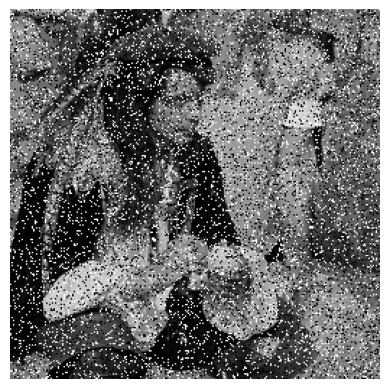

In [6]:
V = 3
s = 1
sigma = 75
B2 = skimage.io.imread("B2.png")
plt.imshow(B2,cmap='gray'); plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

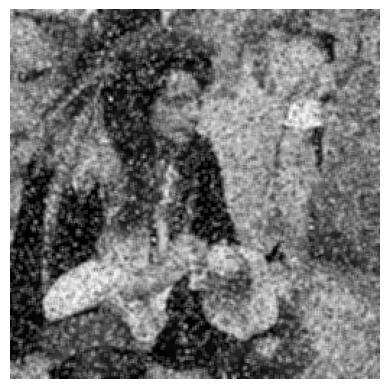

In [9]:
a = Mittelfilter(B2,rechteck(s))
plt.imshow(a,cmap='gray'); plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

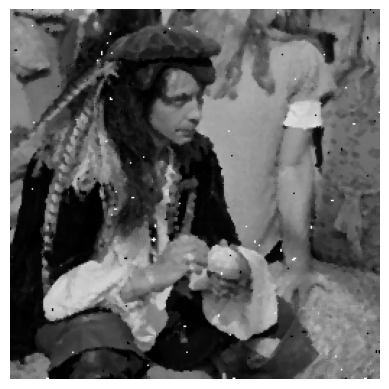

In [10]:
b = Medianfilter(B2,rechteck(s))
plt.imshow(b,cmap='gray'); plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

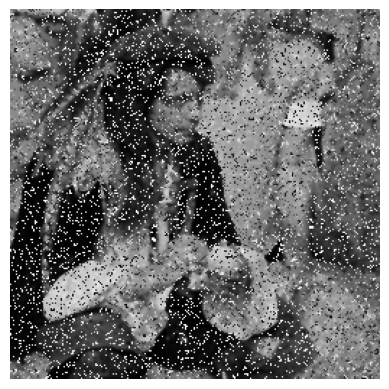

In [11]:
c = Bilfilter(B2,rechteck(s),sigma)
plt.imshow(c,cmap='gray'); plt.axis('off')